In [1]:
import sys
print(sys.executable)

In [2]:
## Basics
import numpy as np
import pandas as pd
import re
import datetime as dt
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Regression using scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, scale

## Setup
warnings.filterwarnings('ignore') 
plt.style.use(['seaborn-pastel'])
%matplotlib inline
%autosave 10

Autosaving every 10 seconds


In [3]:
beijing = pd.read_csv("data/cleaned_beijing.csv",
                      index_col=0, parse_dates=["tradeTime"])
print(beijing.columns.values)
beijing.drop("Cid", axis = 1, inplace=True)
beijing.drop("price", axis = 1, inplace=True)
feature_df = beijing.drop("totalPrice", axis = 1)
response_df = beijing["totalPrice"]
beijing = feature_df.merge(response_df, left_index = True, right_index = True)
beijing.head()

['Lng' 'Lat' 'Cid' 'tradeTime' 'DOM' 'followers' 'totalPrice' 'price'
 'square' 'livingRoom' 'drawingRoom' 'kitchen' 'bathRoom' 'floor'
 'buildingType' 'constructionTime' 'renovationCondition'
 'buildingStructure' 'ladderRatio' 'elevator' 'fiveYearsProperty' 'subway'
 'district' 'communityAverage']


,Lng,Lat,tradeTime,DOM,followers,square,livingRoom,drawingRoom,kitchen,bathRoom,...,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,totalPrice
1,116.475489,40.019520,2016-08-09,1464,106,131.00,2,1,1,1,...,2005,Simplicit,Steel/Concrete,0.217,Has_Elevator,Ownership > 5y,Has_Subway,ChaoYang,56021,415.0
2,116.453917,39.881534,2016-07-28,903,126,132.38,2,2,1,2,...,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,71539,575.0
3,116.561978,39.877145,2016-12-11,1271,48,198.00,3,2,1,3,...,2005,Simplicit,Steel/Concrete,0.500,Has_Elevator,Ownership > 5y,No_Subway,ChaoYang,48160,1030.0
4,116.438010,40.076114,2016-09-30,965,138,134.00,3,1,1,1,...,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5y,No_Subway,ChangPing,51238,297.5
5,116.428392,39.886229,2016-08-28,927,286,81.00,2,1,1,1,...,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5y,Has_Subway,DongCheng,62588,392.0


In [4]:
beijing.drop("Lat", axis = 1, inplace=True)
beijing.drop("Lng", axis = 1, inplace=True)

In [5]:
print(beijing.isnull().sum())
print("\n")
print(beijing.info())

tradeTime              0
DOM                    0
followers              0
square                 0
livingRoom             0
drawingRoom            0
kitchen                0
bathRoom               0
floor                  0
buildingType           0
constructionTime       0
renovationCondition    0
buildingStructure      0
ladderRatio            0
elevator               0
fiveYearsProperty      0
subway                 0
district               0
communityAverage       0
totalPrice             0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 296350 entries, 1 to 296350
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   tradeTime            296350 non-null  datetime64[ns]
 1   DOM                  296350 non-null  int64         
 2   followers            296350 non-null  int64         
 3   square               296350 non-null  float64       
 4   livingRoom           

In [6]:
names = beijing.columns
cat_idx = []
num_idx = []
for i in range(20):
    column = beijing.iloc[:,i]
    if(column.dtype=="O"):
        cat_idx.append(i)
        print("{}\nUnique values:\n{}\n".format(names[i],column.unique()))
    elif(column.dtype!='<M8[ns]'):
        num_idx.append(i)

buildingType
Unique values:
['Tower' 'Plate' 'Plate/Tower' 'Bungalow']

renovationCondition
Unique values:
['Simplicit' 'Hardcover' 'Other' 'Rough']

buildingStructure
Unique values:
['Steel/Concrete' 'Mixed' 'Brick/Concrete' 'Steel' 'Brick/Wood'
 'Unavailable']

elevator
Unique values:
['Has_Elevator' 'No_elevator']

fiveYearsProperty
Unique values:
['Ownership > 5y' 'Ownership < 5y']

subway
Unique values:
['Has_Subway' 'No_Subway']

district
Unique values:
['ChaoYang' 'ChangPing' 'DongCheng' 'MenTouGou' 'XiCheng' 'FengTai'
 'HaiDian' 'FaXing' 'FangShang' 'DaXing' 'ShiJingShan' 'ShunYi' 'TongZhou']



In [7]:
beijing['tradeTime'] = pd.to_datetime(beijing['tradeTime'] )
beijing['tradeTime'] = beijing['tradeTime'] .map(dt.datetime.toordinal)

<Figure size 432x288 with 0 Axes>

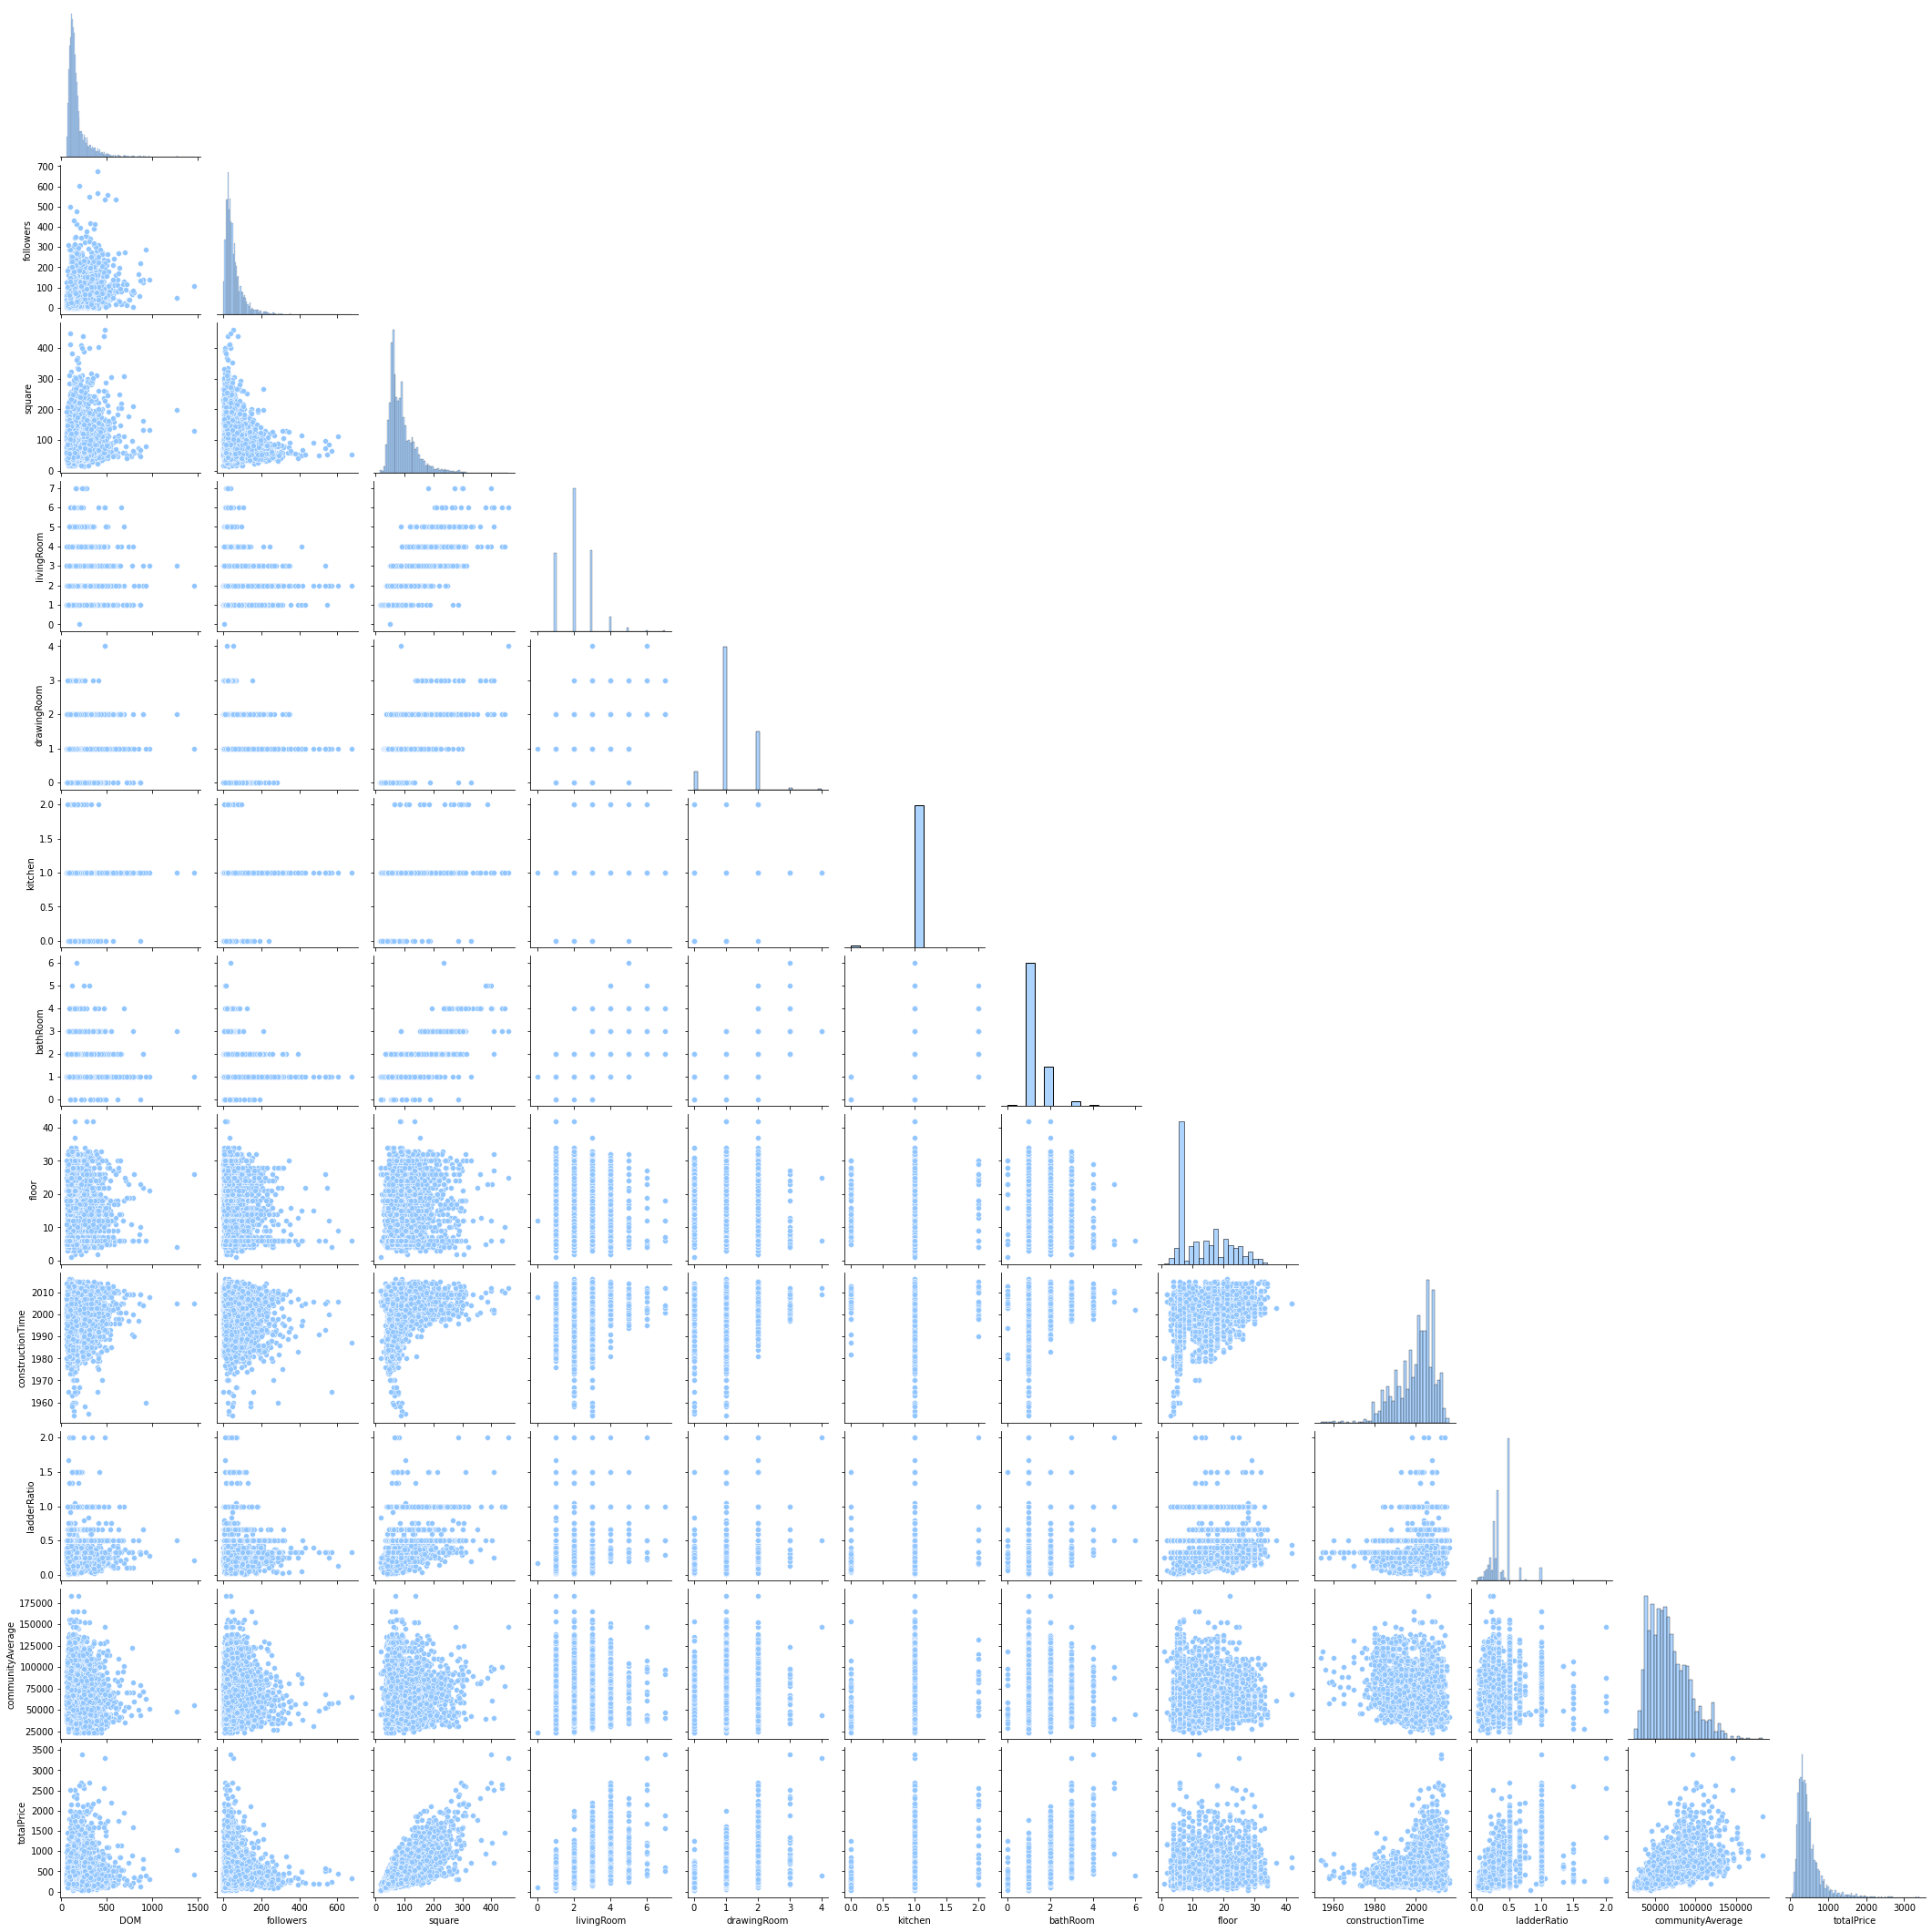

In [8]:
plt.clf()
sns.pairplot(beijing.iloc[:5000,num_idx], corner=True)
plt.show()

## Preprocessing

In [9]:
r_beijing = pd.get_dummies(beijing)
feature_df = r_beijing.drop("totalPrice", axis = 1)
response_df = r_beijing["totalPrice"]
r_beijing = feature_df.merge(response_df, left_index = True, right_index = True)
r_beijing.head()

,tradeTime,DOM,followers,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,constructionTime,...,district_FaXing,district_FangShang,district_FengTai,district_HaiDian,district_MenTouGou,district_ShiJingShan,district_ShunYi,district_TongZhou,district_XiCheng,totalPrice
1,736185,1464,106,131.00,2,1,1,1,26,2005,...,0,0,0,0,0,0,0,0,0,415.0
2,736173,903,126,132.38,2,2,1,2,22,2004,...,0,0,0,0,0,0,0,0,0,575.0
3,736309,1271,48,198.00,3,2,1,3,4,2005,...,0,0,0,0,0,0,0,0,0,1030.0
4,736237,965,138,134.00,3,1,1,1,21,2008,...,0,0,0,0,0,0,0,0,0,297.5
5,736204,927,286,81.00,2,1,1,1,6,1960,...,0,0,0,0,0,0,0,0,0,392.0


In [10]:
r_beijing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296350 entries, 1 to 296350
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   tradeTime                         296350 non-null  int64  
 1   DOM                               296350 non-null  int64  
 2   followers                         296350 non-null  int64  
 3   square                            296350 non-null  float64
 4   livingRoom                        296350 non-null  int64  
 5   drawingRoom                       296350 non-null  int64  
 6   kitchen                           296350 non-null  int64  
 7   bathRoom                          296350 non-null  int64  
 8   floor                             296350 non-null  int64  
 9   constructionTime                  296350 non-null  int64  
 10  ladderRatio                       296350 non-null  float64
 11  communityAverage                  296350 non-null  i

## Modelling

In [11]:
X = r_beijing.drop("totalPrice", axis = 1).values
y = r_beijing["totalPrice"].values.reshape(-1,1)
print(X.shape,y.shape)

(296350, 45) (296350, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=193)

### Feature selection using lasso 

In [13]:
lasso = Lasso(alpha = 0.005, normalize = True)

In [14]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.005, normalize=True)

In [15]:
lasso_pred = lasso.predict(X_test)

In [16]:
lasso.score(X_test, y_test)

0.7926620596975772

In [17]:
lasso_coef = lasso.fit(X, y).coef_

<Figure size 432x288 with 0 Axes>

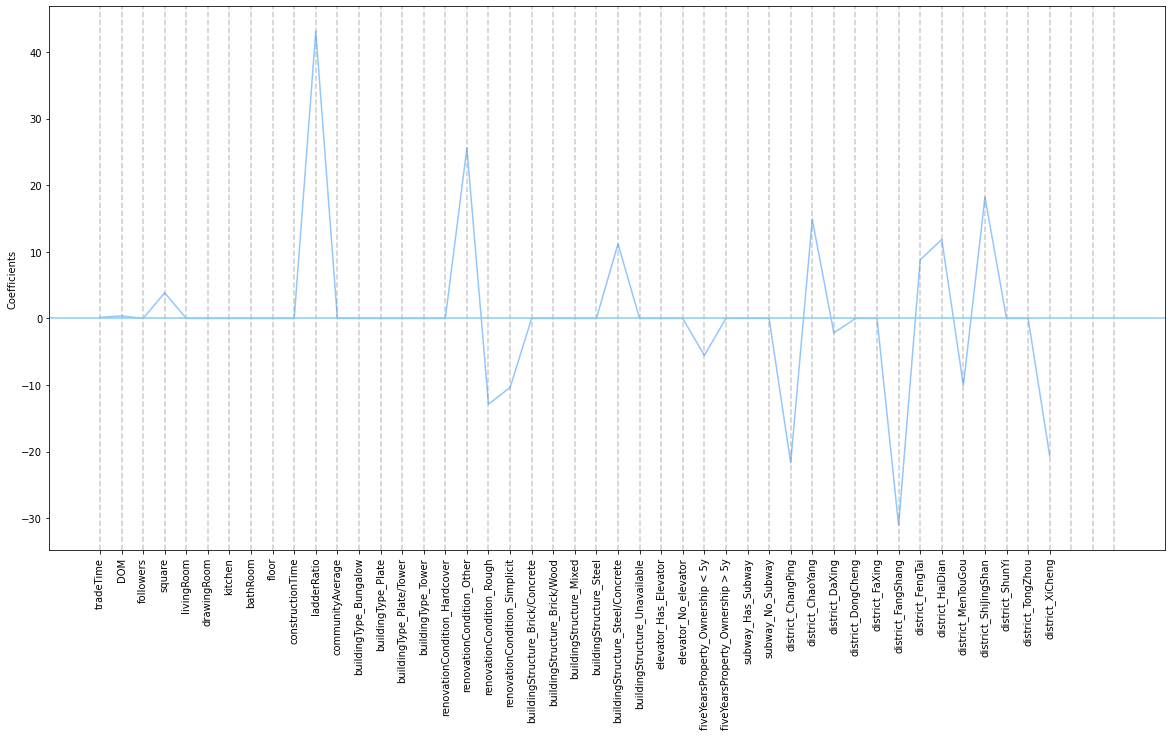

In [18]:
names_coef = [x for x in r_beijing.columns[0:45]]
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(range(len(names_coef)), lasso_coef)
plt.xticks(range(len(names_coef)), names_coef, rotation = 90)
for i in range(0,48):
    plt.axvline(x = i, color = "gray", linestyle='--', alpha = 0.4)
plt.axhline(y = 0, color = "skyblue")
plt.ylabel("Coefficients")
plt.show()

elevator, subway don't seem like a significant features driving the price of houses

In [19]:
s_vars = np.where(abs(lasso_coef)>0)[0].tolist() # significant variables

Important numerical features

In [20]:
for i in s_vars:
    print("{} ".format(names_coef[i],lasso_coef[i]))

tradeTime 
DOM 
square 
ladderRatio 
communityAverage 
renovationCondition_Other 
renovationCondition_Rough 
renovationCondition_Simplicit 
buildingStructure_Steel/Concrete 
fiveYearsProperty_Ownership < 5y 
subway_Has_Subway 
district_ChangPing 
district_ChaoYang 
district_DaXing 
district_FangShang 
district_FengTai 
district_HaiDian 
district_MenTouGou 
district_ShiJingShan 
district_XiCheng 


In [21]:
s_var_names = ['tradeTime','DOM', 'square', 'ladderRatio',
               'communityAverage', 'kitchen', 'renovationCondition', 'buildingStructure',
               'fiveYearsProperty', 'subway','district']
len(s_var_names)

11

In [22]:
X = beijing.loc[:,s_var_names]
y = beijing["totalPrice"].values

In [23]:
X = pd.get_dummies(X)
X = X.values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=193)

### Using regularized ridge regression to fit the model

Plot to identify best alpha

In [25]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [26]:
ridge = Ridge(alpha = 0.1, normalize = True)

In [27]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, normalize=True)

In [28]:
right_pred = ridge.predict(X_test)

In [29]:
ridge.score(X_test, y_test)

0.782806102984255

In [30]:
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 5)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

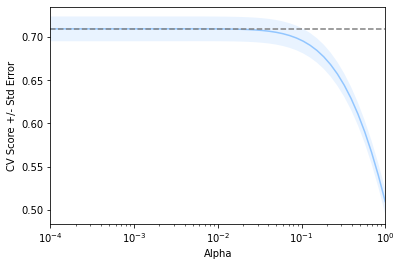

In [31]:
display_plot(ridge_scores, ridge_scores_std)

In [32]:
print("Suggested alpha: {}".format(float(alpha_space[np.where(max(ridge_cv_scores)==ridge_cv_scores)[0]])))

Suggested alpha: 0.00014563484775012445


In [33]:
ridge.alpha =  float(alpha_space[np.where(max(ridge_cv_scores)==ridge_cv_scores)[0]])

In [34]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.00014563484775012445, normalize=True)

In [35]:
right_pred = ridge.predict(X_test)

In [36]:
ridge.score(X_test, y_test)

0.7954567331692419

## Saving the model

In [37]:
filename = 'models/sklearn_model.sav'
pickle.dump(ridge, open(filename, 'wb'))

Loading the model

In [38]:
mdl = pickle.load(open(filename, 'rb'))
mdl.score(X_test, y_test)

0.7954567331692419